In [ ]:
!unzip ./OPP-115_v1_0.zip -d ./OPP-115

In [ ]:
!pip install spacy beautifulsoup4
# !pip -m spacy download en_core_web_sm


In [ ]:
import spacy
import os
from bs4 import BeautifulSoup

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text(separator=" ")

    doc = nlp(clean_text)

    # Use lemmatization and lowercasing
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct]

    clean_text = " ".join(tokens)
    return clean_text


preprocessed_policies_dict = {}
directory = './OPP-115/OPP-115/sanitized_policies'

for filename in os.listdir(directory):
    if filename.endswith('.html'):
        base_name = '_'.join(filename.split('_')[1:]).rsplit('.', 1)[0]
        path = os.path.join(directory, filename)
        with open(path, 'r', encoding='utf-8') as file:
            html_content = file.read()
            preprocessed_text = preprocess_text(html_content)
            preprocessed_policies_dict[base_name] = preprocessed_text


In [ ]:
import pandas as pd
import os

annotations_dir = './OPP-115/OPP-115/annotations/'

# A dictionary to hold all dataframes, key will be the base filename
dataframes = {}

for annotation_filename in os.listdir(annotations_dir):
    if annotation_filename.endswith('.csv'):
        base_name = '_'.join(annotation_filename.split('_')[1:]).rsplit('.', 1)[0]

        annotation_path = os.path.join(annotations_dir, annotation_filename)

        annotation_df = pd.read_csv(annotation_path, header=None)

        dataframes[base_name] = {'categories': annotation_df[5], 'preprocessed_text': preprocessed_policies_dict.get(base_name)}


yahoo_df = dataframes['yahoo.com']
yahoo_df['categories']


0              Other
1              Other
2              Other
3              Other
4              Other
           ...      
162            Other
163    Policy Change
164            Other
165            Other
166            Other
Name: 5, Length: 167, dtype: object

In [ ]:
from collections import defaultdict
import pandas as pd

# Initialize a list to hold the final consolidated dataset
final_dataset = []

for base_name, data in dataframes.items():
    unique_categories_per_text = defaultdict(set)

    for category in data['categories']:
        unique_categories_per_text[data['preprocessed_text']].add(category)

    for text, categories_set in unique_categories_per_text.items():
        final_dataset.append({
            'source': base_name,
            'preprocessed_text': text,
            'categories': list(categories_set)
        })

final_df = pd.DataFrame(final_dataset)

# Display the shape of the DataFrame and the first few rows to verify the structure
print(final_df.shape)
final_df.head()


(115, 3)


,source,preprocessed_text,categories
0,randomhouse.com,privacy policy effective date of privacy ...,"[International and Specific Audiences, Data Se..."
1,communitycoffee.com,privacy statement our commitment to p...,"[Data Security, User Access, Edit and Deletion..."
2,austincc.edu,web privacy statement |||austin commun...,"[Data Security, Policy Change, Data Retention,..."
3,lodgemfg.com,term and conditions please refer to t...,"[International and Specific Audiences, Data Se..."
4,wsmv.com,this web site 's privacy policy |||we ...,"[International and Specific Audiences, Data Se..."


In [ ]:
final_df.iloc[0]['preprocessed_text']

"privacy policy      effective date of privacy policy february 9 2015     |||penguin random house llc prh we we or our respect your concern about privacy and value the relationship we have with you this privacy policy describe our privacy practice with respect to information collect through our website application and any other online service that link to this privacy policy include any website and online service we operate on behalf of our author collectively refer to as the site by use our site you be accept the practice describe in this privacy policy if you do not agree to the term of this privacy policy please do not use the sites we reserve the right to modify or amend the term of our privacy policy from time to time without notice your continue use of our site follow the posting of change to these term will mean you accept those change     |||please click on one of the link below to jump to the list section          what information we collect about you          how we use your 

In [ ]:
# First Party Collection/Use	- maps to -> Lawfulness, Fairness, Transparency | Purpose Limitation | Data Minimization

# Third Party Sharing/Collection - maps to ->	Lawfulness, Fairness, Transparency | Purpose Limitation | Data Minimization

# User Choice/Control	 - maps to -> Lawfulness, Fairness, Transparency

# User Access, Edit, and Deletion  - maps to ->	Lawfulness, Fairness, Transparency | Accuracy

# Data Retention  - maps to ->	Storage Limitation

# Data Security  - maps to -> Integrity and Confidentiality

# Policy Change	  - maps to ->	 Lawfulness, Fairness, Transparency

# Do Not Track

# International and Specific Audiences	  - maps to ->	 Lawfulness, Fairness, Transparency

# Other	(No Direct Mapping)

label_mapping = {
    "First Party Collection/Use": [1, 2, 3],
    "Third Party Sharing/Collection": [1, 2, 3],
    "User Choice/Control": [1],
    "User Access, Edit, and Deletion": [1, 4],
    "Data Retention": [5],
    "Data Security": [6],
    "Policy Change": [1],
    "Do Not Track": [],
    "International and Specific Audiences": [1],
    "Other": []
}

# where:

# 1 is lawfulness, fairness and transparency

# 2 is purpose limitation

# 3 is data minimization

# 4 is accuracy

# 5 is storage limitation

# 6 is integrity and confidentiality

# 7 is accountability

def transform_document_labels(document_labels):
    document_new_labels_set = set()
    for label in document_labels:
        # Add the new categories to the set if the label is in the mapping
        if label in label_mapping:
            document_new_labels_set.update(label_mapping[label])
    return sorted(list(document_new_labels_set))

final_df['gdpr_principles'] = final_df['categories'].apply(transform_document_labels)

total_principles = 7

final_df['compliance_percentage'] = final_df['gdpr_principles'].apply(lambda x: (len(x) / total_principles) * 100)

final_df.head()



,source,preprocessed_text,categories,gdpr_principles,compliance_percentage
0,randomhouse.com,privacy policy effective date of privacy ...,"[International and Specific Audiences, Data Se...","[1, 2, 3, 5, 6]",71.428571
1,communitycoffee.com,privacy statement our commitment to p...,"[Data Security, User Access, Edit and Deletion...","[1, 2, 3, 6]",57.142857
2,austincc.edu,web privacy statement |||austin commun...,"[Data Security, Policy Change, Data Retention,...","[1, 2, 3, 5, 6]",71.428571
3,lodgemfg.com,term and conditions please refer to t...,"[International and Specific Audiences, Data Se...","[1, 2, 3, 6]",57.142857
4,wsmv.com,this web site 's privacy policy |||we ...,"[International and Specific Audiences, Data Se...","[1, 2, 3, 5, 6]",71.428571


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

encoded_labels = mlb.fit_transform(final_df['gdpr_principles'])


In [ ]:
preprocessed_policies = final_df['preprocessed_text'].tolist()


In [ ]:
!pip install -U transformers
!pip install accelerate -U


In [ ]:
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EvalPrediction
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from transformers import BertConfig
from sklearn.metrics import mean_squared_error, mean_absolute_error

class PrivacyPolicyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)


# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(mlb.classes_), pad_token_id=tokenizer.eos_token_id)

assert model.config.pad_token_id is not None, "Pad token not set in model configuration."

model.resize_token_embeddings(len(tokenizer))


# model.classifier = torch.nn.Linear(model.classifier.in_features, len(mlb.classes_))
# model.num_labels = len(mlb.classes_)


train_texts, val_texts, train_labels, val_labels = train_test_split(
    preprocessed_policies, encoded_labels, test_size=0.2, random_state=42
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = PrivacyPolicyDataset(train_encodings, train_labels)
val_dataset = PrivacyPolicyDataset(val_encodings, val_labels)

# def compute_metrics(p: EvalPrediction):
#     preds = np.argmax(p.predictions, axis=1)
#     precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
#     acc = accuracy_score(p.label_ids, preds)
#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }


def compute_metrics(p: EvalPrediction):
    # Threshold for converting probabilities to binary output
    threshold = 0.5
    # Convert logits to probabilities
    probabilities = torch.sigmoid(torch.tensor(p.predictions)).numpy()
    # Apply threshold to get binary multi-label outputs
    preds = (probabilities > threshold).astype(int)

    # You can compute accuracy in a way that makes sense for your multi-label setup
    # Example: Exact Match Ratio
    exact_match_ratio = np.all(preds == p.label_ids, axis=1).mean()

    # F1 score - average = 'samples' considers each output label's prediction
    f1 = f1_score(p.label_ids, preds, average='samples')

    return {
        'exact_match_ratio': exact_match_ratio,
        'f1_score_samples': f1,
    }


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Exact Match Ratio,F1 Score Samples
1,No log,3.371719,0.000000,0.272774
2,No log,3.269199,0.000000,0.272774
3,No log,3.081763,0.000000,0.272774
4,No log,2.797375,0.000000,0.269462
5,No log,2.410604,0.000000,0.343478
6,No log,1.990369,0.000000,0.394203
7,No log,1.541975,0.000000,0.514803
8,No log,0.972542,0.000000,0.653520
9,No log,0.707988,0.173913,0.802968
10,No log,0.484788,0.391304,0.906487


TrainOutput(global_step=120, training_loss=1.8056218465169271, metrics={'train_runtime': 34.9781, 'train_samples_per_second': 26.302, 'train_steps_per_second': 3.431, 'total_flos': 240399522201600.0, 'train_loss': 1.8056218465169271, 'epoch': 10.0})

In [ ]:
results = trainer.evaluate()

print(results)


{'eval_loss': 0.4847877621650696, 'eval_exact_match_ratio': 0.391304347826087, 'eval_f1_score_samples': 0.9064872325741892, 'eval_runtime': 0.2706, 'eval_samples_per_second': 84.984, 'eval_steps_per_second': 11.085, 'epoch': 10.0}


In [ ]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json')

In [ ]:
!zip -r saved_model.zip saved_model/

from google.colab import files
files.download('saved_model.zip')


  adding: saved_model/ (stored 0%)
  adding: saved_model/special_tokens_map.json (deflated 74%)
  adding: saved_model/merges.txt (deflated 53%)
  adding: saved_model/vocab.json (deflated 68%)
  adding: saved_model/config.json (deflated 55%)
  adding: saved_model/tokenizer_config.json (deflated 55%)
  adding: saved_model/model.safetensors (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r logs.zip logs/
!zip -r results.zip results/


  adding: logs/ (stored 0%)
  adding: logs/events.out.tfevents.1713871033.8f1236231874.2574.1 (deflated 62%)
  adding: logs/events.out.tfevents.1713868106.8f1236231874.2574.0 (deflated 62%)
  adding: logs/events.out.tfevents.1713871158.8f1236231874.18326.0 (deflated 63%)
  adding: logs/events.out.tfevents.1713871193.8f1236231874.18326.1 (deflated 28%)
  adding: results/ (stored 0%)


In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained('./saved_model')
# tokenizer = BertTokenizer.from_pretrained('./saved_model')


In [ ]:
!pip install tensorboard

['eval/loss', 'eval/exact_match_ratio', 'eval/f1_score_samples', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
11
11


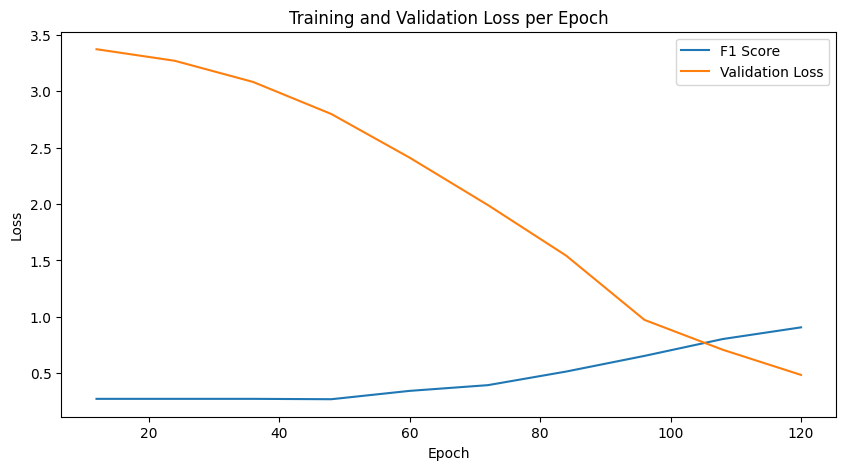

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log files
logdir = './logs'

# Load the data
ea = event_accumulator.EventAccumulator(logdir)
ea.Reload()  # Loads the data from disk

print(ea.Tags()['scalars'])

# Assuming you have scalar summaries for training and validation loss
training_loss = ea.scalars.Items('eval/f1_score_samples')
validation_loss = ea.scalars.Items('eval/loss')

print(len(training_loss))
print(len(validation_loss))

# Extracting the data for plotting
epochs = [x.step for x in training_loss]
training_losses = [x.value for x in training_loss]
validation_losses = [x.value for x in validation_loss]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='F1 Score')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


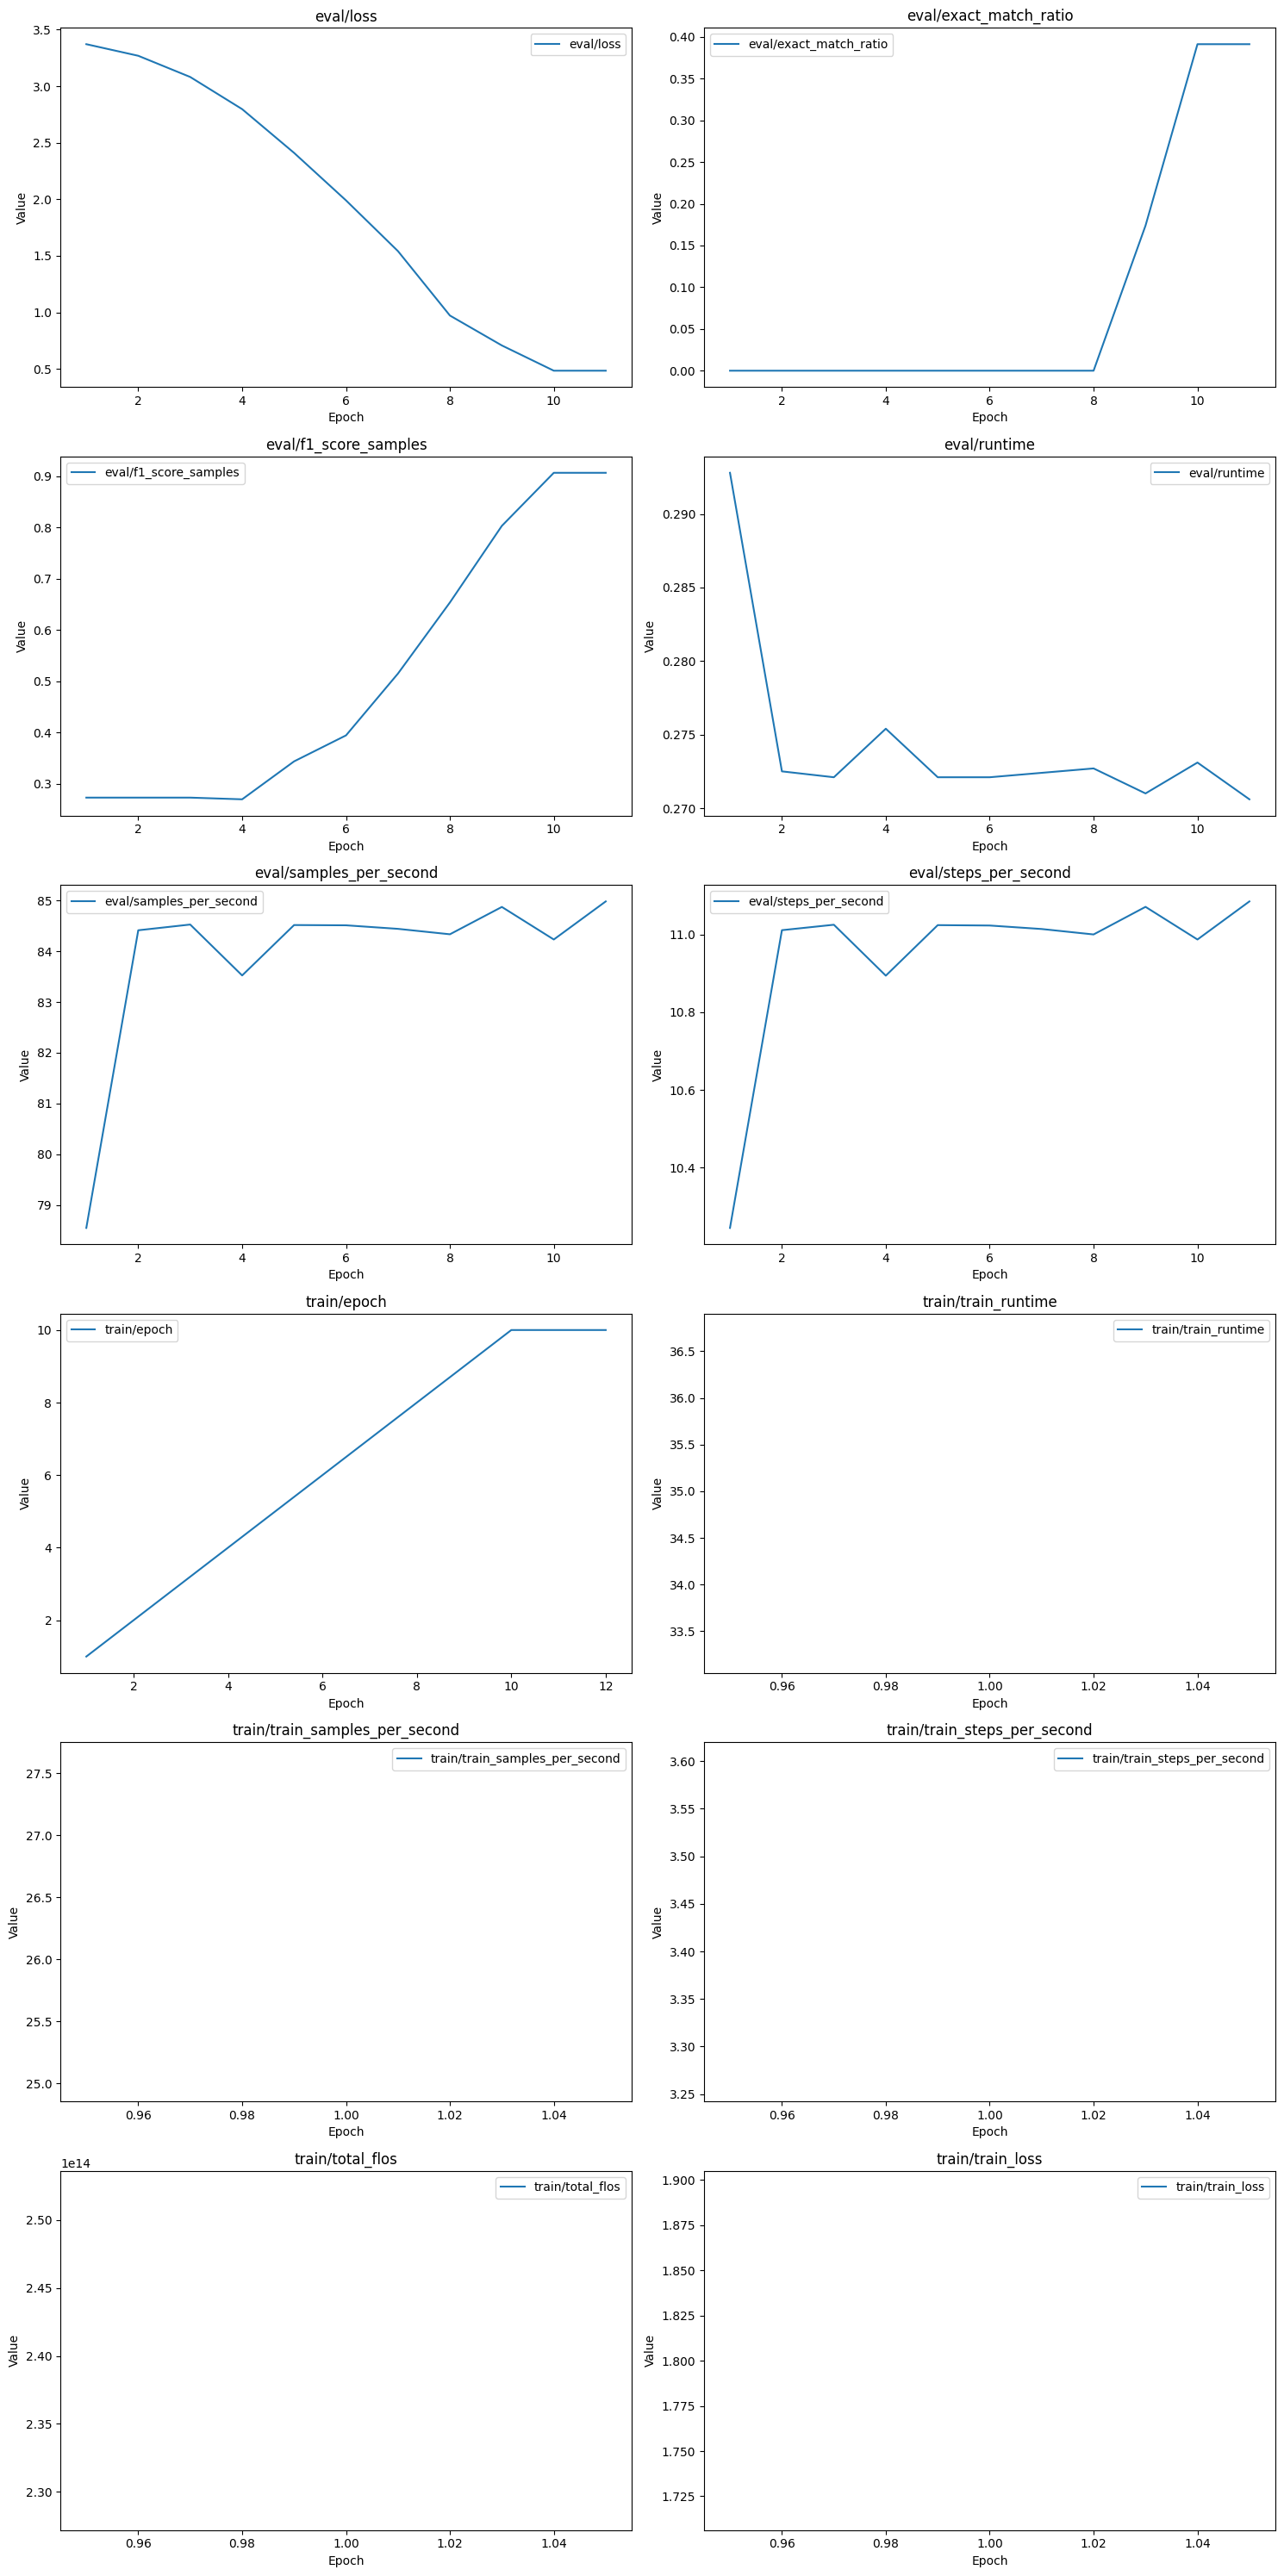

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'ea' is your EventAccumulator loaded with TensorBoard logs
ea.Reload()

# Function to extract metric values
def extract_metric(metric_name):
    if metric_name in ea.scalars.Keys():
        return [x.value for x in ea.scalars.Items(metric_name)]
    else:
        return []

# Extract metrics
metrics_dict = {key: extract_metric(key) for key in [
    'eval/loss', 'eval/exact_match_ratio', 'eval/f1_score_samples',
    'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second',
    'train/epoch', 'train/train_runtime', 'train/train_samples_per_second',
    'train/train_steps_per_second', 'train/total_flos', 'train/train_loss'
]}

# Create subplots
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
axs = axs.flatten()  # To iterate easily over subplots for different metrics

# Plot each metric
for i, (metric, values) in enumerate(metrics_dict.items()):
    epochs = range(1, len(values)+1)
    axs[i].plot(epochs, values, label=metric)
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()
